In [17]:
from keras.layers import Input, Dense, Conv2D, Flatten, Activation, BatchNormalization, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import itertools
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
get_ipython().run_line_magic('matplotlib', 'inline')
from collections import defaultdict
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
import pandas as pd
import numpy as np

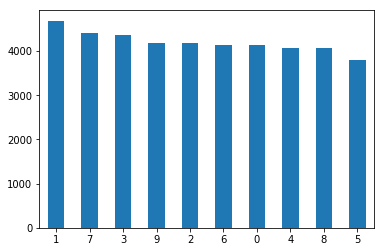

In [2]:
#load data
data_train = pd.read_csv(".\\data\\DC\\train\\train.csv")
data_train['label'].value_counts().plot.bar(rot=0)

In [3]:
def pre_process_data(data_x, data_y):
    data_s_x = data_x / 255
    data_s_x = data_s_x.values.reshape(data_x.shape[0], 28, 28, 1)
    data_y = to_categorical(data_y.values)
    print(data_y.shape)
    return data_s_x, data_y

In [4]:
def display(data, label):
    for i in range(data.shape[0]):
        plt.subplot(330 + (i+1))
        plt.imshow(data[i,:,:,0], cmap=plt.get_cmap('gray'))
        if label is not None:
            plt.title(label[i])
    plt.show()

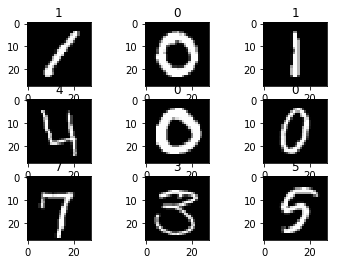

In [5]:
display(data_train.iloc[:,1:].values.reshape(data_train.shape[0], 28, 28, 1)[0:9],data_train.iloc[:, 0].values[0:9])

(42000, 10)


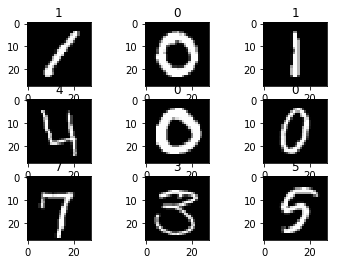

In [6]:
data_x, data_y = pre_process_data(data_train.iloc[:,1:], data_train.iloc[:, 0])
display(data_x[0:9], np.argmax(data_y[0:9], axis=1))

In [7]:
def get_model():
    inputs = Input(shape=(28, 28, 1))

    # a layer instance is callable on a tensor, and returns a tensor
    x = Conv2D(16, kernel_size=7, padding='same', activation='relu')(inputs)
    x = Conv2D(32, kernel_size=7, padding='same', activation='relu')(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=5, padding='valid', activation='relu')(x)
    x = Conv2D(128, kernel_size=5, padding='valid', activation='relu')(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, padding='valid', activation='relu')(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D(pool_size=(1, 1))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(10, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [8]:
model = get_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        800       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1

In [9]:
def get_data_gen(X_train):
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    datagen.fit(X_train)
    return datagen

In [10]:
def get_learning_rate():
    return ReduceLROnPlateau(monitor='val_acc', 
                             patience=3, 
                             verbose=1, 
                             factor=0.5, 
                             min_lr=0.00001)

In [12]:
def get_accuracy(x, y, epochs, batch_size):
    skf = StratifiedKFold(n_splits=10)
    predicted_y = []
    expected_y = []
    history_y = []
    model_y = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        x_train, y_train = pre_process_data(x_train, y_train)
        x_test, y_test = pre_process_data(x_test, y_test)
        datagen = get_data_gen(x_train)
        learning_rate_reduction = get_learning_rate()
        model = get_model()
        history = model.fit(x=x_train, y=y_train, epochs=epochs)
#       If we have time this is better for fitting data
#         history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                                       epochs = epochs,
#                                       verbose = 1, steps_per_epoch=x_train.shape[0], callbacks=[learning_rate_reduction])
        predicted_y.extend(np.argmax(model.predict(x_test), axis = 1))
        expected_y.extend(np.argmax(y_test, axis = 1))
        history_y.append(history)
        model_y.append(model)
    return predicted_y, expected_y, history_y, model_y

In [13]:
expected_y, predicted_y, history_y, model_y = get_accuracy(data_train.iloc[:,1:], data_train.iloc[:, 0], 1, 1000)
accuracy = metrics.accuracy_score(expected_y, predicted_y)
print("Accuracy: " + accuracy.__str__())

(37794, 10)
(4206, 10)
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
37794/37794 [==============================] - 22s 590us/step - loss: 0.1618 - acc: 0.9523
(37796, 10)
(4204, 10)
Epoch 1/1
37796/37796 [==============================] - 19s 495us/step - loss: 0.1656 - acc: 0.9519
(37798, 10)
(4202, 10)
Epoch 1/1
37798/37798 [==============================] - 20s 525us/step - loss: 0.1643 - acc: 0.9521
(37799, 10)
(4201, 10)
Epoch 1/1
37799/37799 [==============================] - 20s 539us/step - loss: 0.1578 - acc: 0.9535
(37800, 10)
(4200, 10)
Epoch 1/1
37800/37800 [==============================] - 19s 515us/step - loss: 0.1587 - acc: 0.9525
(37801, 10)
(4199, 10)
Epoch 1/1
37801/37801 [==============================] - 21s 543us/step - loss: 0.1587 - acc: 0.9530
(37801, 10)
(4199, 10)
Epoch 1/1
37801/37801 [==============================] - 21s 559us/step - loss: 0.1564 - acc: 0.9538
(37803, 10)
(4197, 10)
Epoch 1/1
37803/37803 [==============================] - 21s 

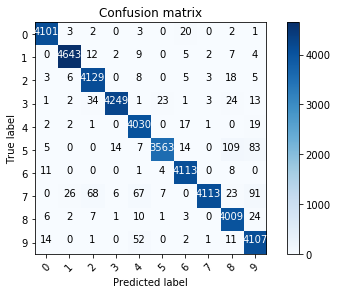

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model_y[0].predict(data_x)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(data_y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

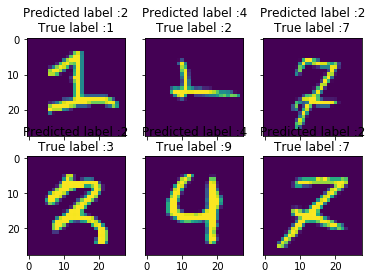

In [20]:
X_val = data_x
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [147]:
import json
with open("digit.json", "w") as json_file:
    json_file.write(model.to_json())
model.save_weights("digit.h5")